In [1]:
from IPython.core.interactiveshell import InteractiveShell

# Display outputs from all lines when they exist
InteractiveShell.ast_node_interactivity = "all" # "last"

In [2]:
import pandas as pd

pd.set_option('max_columns', None)

In [3]:
REWRITE_BACKUPS_FLAG = True

# Import directly from data

In [4]:
# Read from CSV
posts_2018_df = pd.read_csv("2018_posts.csv")
comms_2018_df = pd.read_csv("2018_comments.csv")
posts_2019_df = pd.read_csv("2019_posts.csv")
comms_2019_df = pd.read_csv("2019_comments_partial.csv")

print(posts_2018_df.shape, comms_2018_df.shape)
print(posts_2019_df.shape, comms_2019_df.shape)

/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,3,36,39,41,42,43,45,47,48,51,52,54,56,58,59,60,62,64,65,68,69,71,72,74,83,84,86,87,88,89,90,91,94,95,99,102,103,104,105,107,110,114,115,117,120,124,125,126,128,130,131) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,11,27,28,29,31,32,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,6,20,44,56,57,64,66,67,68,75,77,79,80,81,82,84,86,87,88,89,92,93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj

(17598, 132) (448947, 40)
(244595, 95) (1716502, 46)


In [5]:
posts_df = posts_2018_df.append(posts_2019_df).reset_index(drop=True)
comms_df = comms_2018_df.append(comms_2019_df).reset_index(drop=True)

print(posts_df.shape)
print(comms_df.shape)

(262193, 146)
(2165449, 48)


## Filter for posts that use bot judgement tags

In [6]:
posts_df[posts_df['id']=='9zgc4m'] # the ID of the first bot implementation announcement

# only include posts AFTER that announcement cutoff
posts_df = posts_df[posts_df['created_utc'] > posts_df[posts_df['id']=='9zgc4m'].iloc[0]['created_utc']].reset_index(drop=True)
print(posts_df.shape)

# and cut down the comments df to only include data for posts within that dataset, while we're at it
comms_df = comms_df[comms_df['link_id'].apply(lambda x: str(x)[3:]).isin(posts_df['id'])].reset_index(drop=True)
print(comms_df.shape)

,author,author_flair_css_class,author_flair_text,brand_safe,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,retrieved_on,score,selftext,spoiler,stickied,subreddit,subreddit_id,subreddit_type,suggested_sort,thumbnail,title,url,whitelist_status,thumbnail_height,thumbnail_width,link_flair_text,banned_by,edited,media.oembed.description,media.oembed.height,media.oembed.html,media.oembed.provider_name,media.oembed.provider_url,media.oembed.thumbnail_height,media.oembed.thumbnail_url,media.oembed.thumbnail_width,media.oembed.title,media.oembed.type,media.oembed.version,media.oembed.width,media.type,media_embed.content,media_embed.height,media_embed.scrolling,media_embed.width,secure_media.oembed.description,secure_media.oembed.height,secure_media.oembed.html,secure_media.oembed.provider_name,secure_media.oembed.provider_url,secure_media.oembed.thumbnail_height,secure_media.oembed.thumbnail_url,secure_media.oembed.thumbnail_width,secure_media.oembed.title,secure_media.oembed.type,secure_media.oembed.version,secure_media.oembed.width,secure_media.type,secure_media_embed.content,secure_media_embed.height,secure_media_embed.media_domain_url,secure_media_embed.scrolling,secure_media_embed.width,link_flair_css_class,post_hint,preview.enabled,preview.images,author_flair_richtext,author_flair_type,link_flair_richtext,link_flair_text_color,link_flair_type,rte_mode,author_flair_background_color,author_flair_text_color,media.oembed.author_name,media.oembed.author_url,secure_media.oembed.author_name,secure_media.oembed.author_url,link_flair_background_color,link_flair_template_id,author_cakeday,gilded,send_replies,no_follow,subreddit_subscribers,crosspost_parent,crosspost_parent_list,is_original_content,wls,pwls,media_only,author_id,is_meta,archived,author_created_utc,author_flair_template_id,author_fullname,author_patreon_flair,can_gild,category,content_categories,distinguished,hidden,is_robot_indexable,media,quarantine,removal_reason,secure_media,subreddit_name_prefixed,gildings.gid_1,gildings.gid_2,gildings.gid_3,all_awardings,allow_live_comments,awarders,total_awards_received,treatment_tags,upvote_ratio,author_premium,removed_by_category,updated_utc,preview.reddit_video_preview.dash_url,preview.reddit_video_preview.duration,preview.reddit_video_preview.fallback_url,preview.reddit_video_preview.height,preview.reddit_video_preview.hls_url,preview.reddit_video_preview.is_gif,preview.reddit_video_preview.scrubber_media_url,preview.reddit_video_preview.transcoding_status,preview.reddit_video_preview.width,steward_reports,og_description,og_title,removed_by
10541,TheOutrageousClaire,badge,Colo-rectal Surgeon,NaN,False,False,1542909710,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zgc4m,True,False,True,False,False,104,0,False,house_only,/r/AmItheAsshole/comments/9zgc4m/change_is_com...,False,1542909711,1,"We've got 200,000 subscribers now and it feels...",False,False,AmItheAsshole,t5_2xhvq,public,NaN,self,Change is coming....,https://www.reddit.com/r/AmItheAsshole/comment...,house_only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],text,[],dark,text,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,200579.0,NaN,NaN,False,1.0,1.0,False,NaN,False,NaN,NaN,NaN,t2_7j6x2,False,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(251651, 146)
(1913807, 48)


In [7]:
# Create list of users that should always be filtered out from the counts
restricted_users_list = ['AutoModerator', 'Judgement_Bot_AITA']

In [8]:
# Judgement tags are in {'NTA', 'YTA', 'NAH', 'ESH', 'INFO', 'SHP' (not formal after a certain point but still commonly quoted)}
potential_tags = ['NTA', 'YTA', 'NAH', 'ESH', 'INFO', 'SHP']

In [9]:
posts_df[:2]
comms_df[:2]

,author,author_flair_css_class,author_flair_text,brand_safe,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,retrieved_on,score,selftext,spoiler,stickied,subreddit,subreddit_id,subreddit_type,suggested_sort,thumbnail,title,url,whitelist_status,thumbnail_height,thumbnail_width,link_flair_text,banned_by,edited,media.oembed.description,media.oembed.height,media.oembed.html,media.oembed.provider_name,media.oembed.provider_url,media.oembed.thumbnail_height,media.oembed.thumbnail_url,media.oembed.thumbnail_width,media.oembed.title,media.oembed.type,media.oembed.version,media.oembed.width,media.type,media_embed.content,media_embed.height,media_embed.scrolling,media_embed.width,secure_media.oembed.description,secure_media.oembed.height,secure_media.oembed.html,secure_media.oembed.provider_name,secure_media.oembed.provider_url,secure_media.oembed.thumbnail_height,secure_media.oembed.thumbnail_url,secure_media.oembed.thumbnail_width,secure_media.oembed.title,secure_media.oembed.type,secure_media.oembed.version,secure_media.oembed.width,secure_media.type,secure_media_embed.content,secure_media_embed.height,secure_media_embed.media_domain_url,secure_media_embed.scrolling,secure_media_embed.width,link_flair_css_class,post_hint,preview.enabled,preview.images,author_flair_richtext,author_flair_type,link_flair_richtext,link_flair_text_color,link_flair_type,rte_mode,author_flair_background_color,author_flair_text_color,media.oembed.author_name,media.oembed.author_url,secure_media.oembed.author_name,secure_media.oembed.author_url,link_flair_background_color,link_flair_template_id,author_cakeday,gilded,send_replies,no_follow,subreddit_subscribers,crosspost_parent,crosspost_parent_list,is_original_content,wls,pwls,media_only,author_id,is_meta,archived,author_created_utc,author_flair_template_id,author_fullname,author_patreon_flair,can_gild,category,content_categories,distinguished,hidden,is_robot_indexable,media,quarantine,removal_reason,secure_media,subreddit_name_prefixed,gildings.gid_1,gildings.gid_2,gildings.gid_3,all_awardings,allow_live_comments,awarders,total_awards_received,treatment_tags,upvote_ratio,author_premium,removed_by_category,updated_utc,preview.reddit_video_preview.dash_url,preview.reddit_video_preview.duration,preview.reddit_video_preview.fallback_url,preview.reddit_video_preview.height,preview.reddit_video_preview.hls_url,preview.reddit_video_preview.is_gif,preview.reddit_video_preview.scrubber_media_url,preview.reddit_video_preview.transcoding_status,preview.reddit_video_preview.width,steward_reports,og_description,og_title,removed_by
0,hshsvdhsiabs,NaN,NaN,NaN,False,False,1542909884,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zgd5n,True,False,True,False,False,10,0,False,house_only,/r/AmItheAsshole/comments/9zgd5n/wibta_for_not...,False,1542909885,1,I had this best friend in high school and we b...,False,False,AmItheAsshole,t5_2xhvq,public,NaN,self,WIBTA for not responding to an ex friends nice...,https://www.reddit.com/r/AmItheAsshole/comment...,house_only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],text,[],dark,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,200588.0,NaN,NaN,False,1.0,1.0,False,NaN,False,NaN,NaN,NaN,t2_1m2ny8mg,False,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ilikeallburgers,NaN,NaN,NaN,False,False,1542910040,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zge0j,True,False,True,False,False,8,0,False,house_only,/r/AmItheAsshole/comments/9zge0j/aita_for_not_...,False,1542910040,1,My cousin and her fiance are getting married i...,False,False,AmItheAsshole,t5_2xhvq,publi

,approved_at_utc,author,author_flair_css_class,author_flair_text,banned_at_utc,body,can_mod_post,collapsed,collapsed_reason,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,author_cakeday,author_flair_background_color,author_flair_richtext,author_flair_text_color,author_flair_type,no_follow,rte_mode,send_replies,author_flair_template_id,author_id,author_fullname,gildings.gid_1,gildings.gid_2,gildings.gid_3,author_patreon_flair,all_awardings,locked,total_awards_received,associated_award,author_premium,awarders,collapsed_because_crowd_control,comment_type,top_awarded_type,treatment_tags,steward_reports
0,NaN,AutoModerator,NaN,NaN,NaN,^^^^AUTOMOD ***This is a copy of the above po...,False,False,NaN,1542909885,moderator,False,ea8xh7v,False,t3_9zgd5n,t3_9zgd5n,/r/AmItheAsshole/comments/9zgd5n/wibta_for_not...,1.542910e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,False,NaN,NaN,t2_6l4z3,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ursa-majcr,NaN,NaN,NaN,"NTA. you don’t owe her anything, certainly not...",False,False,NaN,1542910265,NaN,False,ea8xxe0,False,t3_9zgd5n,t3_9zgd5n,/r/AmItheAsshole/comments/9zgd5n/wibta_for_not...,1.542910e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,True,NaN,NaN,t2_17d1fuhb,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Brief post comment count analysis

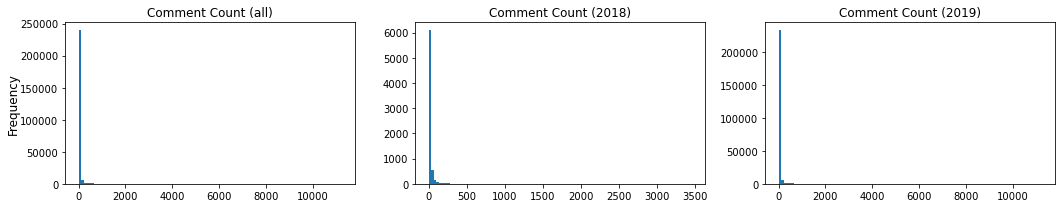

/tmp/ipykernel_34506/964200700.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _ = axs[0].hist(posts_df[posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
/tmp/ipykernel_34506/964200700.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _ = axs[1].hist(posts_df[posts_df['created_utc']<1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
/tmp/ipykernel_34506/964200700.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _ = axs[2].hist(posts_df[posts_df['created_utc']>=1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)


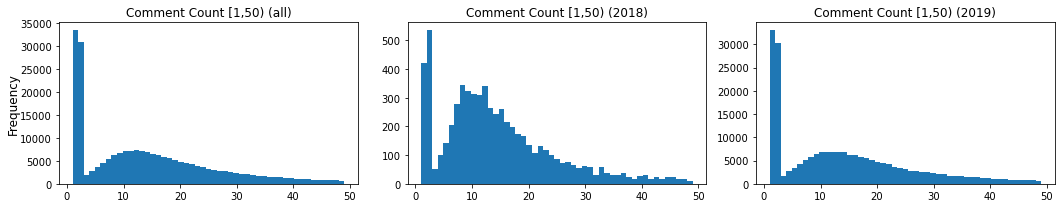

/tmp/ipykernel_34506/964200700.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _ = axs[0].hist(posts_df[posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
/tmp/ipykernel_34506/964200700.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _ = axs[1].hist(posts_df[posts_df['created_utc']<1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
/tmp/ipykernel_34506/964200700.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _ = axs[2].hist(posts_df[posts_df['created_utc']>=1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)


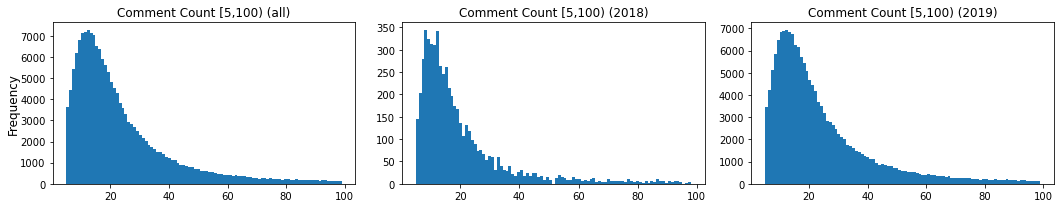

In [10]:
# Identify the post length distribution

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 3]
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)
n_bins = 100

_ = axs[0].hist(posts_df['num_comments'], bins=n_bins)
_ = axs[0].set_title('Comment Count (all)')
_ = axs[1].hist(posts_df[posts_df['created_utc']<1546318855]['num_comments'], bins=n_bins)
_ = axs[1].set_title('Comment Count (2018)')
_ = axs[2].hist(posts_df[posts_df['created_utc']>=1546318855]['num_comments'], bins=n_bins)
_ = axs[2].set_title('Comment Count (2019)')
_ = fig.supylabel('Frequency')

plt.show()

plt.rcParams['figure.figsize'] = [15, 3]
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)
comm_min = 1
comm_max = 50
n_bins = comm_max-comm_min

_ = axs[0].hist(posts_df[posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
_ = axs[0].set_title('Comment Count [1,50) (all)')
_ = axs[1].hist(posts_df[posts_df['created_utc']<1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
_ = axs[1].set_title('Comment Count [1,50) (2018)')
_ = axs[2].hist(posts_df[posts_df['created_utc']>=1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
_ = axs[2].set_title('Comment Count [1,50) (2019)')
_ = fig.supylabel('Frequency')

plt.show()

plt.rcParams['figure.figsize'] = [15, 3]
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)
comm_min = 5
comm_max = 100
n_bins = comm_max-comm_min

_ = axs[0].hist(posts_df[posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
_ = axs[0].set_title('Comment Count [5,100) (all)')
_ = axs[1].hist(posts_df[posts_df['created_utc']<1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
_ = axs[1].set_title('Comment Count [5,100) (2018)')
_ = axs[2].hist(posts_df[posts_df['created_utc']>=1546318855][posts_df['num_comments']>=comm_min][posts_df['num_comments']<comm_max]['num_comments'], bins=n_bins)
_ = axs[2].set_title('Comment Count [5,100) (2019)')
_ = fig.supylabel('Frequency')

plt.show()

# Filter posts by comment count

In [11]:
# Filter out the posts which dont have many comments attributed to them in the dataset

temp_sizefilter = 50

# Set overall minimum comment count
posts_sizefilter_df = posts_df[posts_df['num_comments']>temp_sizefilter].reset_index(drop=True)
posts_df.shape, posts_sizefilter_df.shape

# Cut out comment data from posts that were filtered out via previous restriction
comms_sizefilter_df = comms_df[comms_df['link_id'].apply(lambda x: str(x)[3:]).isin(posts_sizefilter_df['id'])].reset_index(drop=True)
comms_df.shape, comms_sizefilter_df.shape

# Cut out post data which does not have any downloaded comment data associated
temp_linkset = set(comms_sizefilter_df['link_id'])
posts_sizefilter_df = posts_sizefilter_df[posts_sizefilter_df['id'].apply(lambda x: f't3_{x}' in temp_linkset)].reset_index(drop=True)
posts_sizefilter_df.shape

((251651, 146), (27474, 146))

((1913807, 48), (1230716, 48))

(5490, 146)

In [12]:
# SMALL DATASET, POST-BOT FILTERED:
# 34917 posts with >10 comments
# 18228 posts with >20 comments
# 10812 posts with >30 comments
#  7321 posts with >40 comments
#  5490 posts with >50 comments

## Backup size filter (AFTER THIS POINT, EVERYTHING IS SIZEFILTERED)

In [13]:
# Backup the sizefiltered version of dataset

if REWRITE_BACKUPS_FLAG:
    posts_df = posts_sizefilter_df
    posts_df.to_csv(f'backup_posts_sizefilter_df.csv', index=False)
    comms_df = comms_sizefilter_df
    comms_df.to_csv(f'backup_comms_sizefilter_df.csv', index=False)

# Recover from backup

posts_df = pd.read_csv(f'backup_posts_sizefilter_df.csv')
comms_df = pd.read_csv(f'backup_comms_sizefilter_df.csv')

posts_df[:2]
comms_df[:2]

/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (92,109) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,8,11,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,author,author_flair_css_class,author_flair_text,brand_safe,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,retrieved_on,score,selftext,spoiler,stickied,subreddit,subreddit_id,subreddit_type,suggested_sort,thumbnail,title,url,whitelist_status,thumbnail_height,thumbnail_width,link_flair_text,banned_by,edited,media.oembed.description,media.oembed.height,media.oembed.html,media.oembed.provider_name,media.oembed.provider_url,media.oembed.thumbnail_height,media.oembed.thumbnail_url,media.oembed.thumbnail_width,media.oembed.title,media.oembed.type,media.oembed.version,media.oembed.width,media.type,media_embed.content,media_embed.height,media_embed.scrolling,media_embed.width,secure_media.oembed.description,secure_media.oembed.height,secure_media.oembed.html,secure_media.oembed.provider_name,secure_media.oembed.provider_url,secure_media.oembed.thumbnail_height,secure_media.oembed.thumbnail_url,secure_media.oembed.thumbnail_width,secure_media.oembed.title,secure_media.oembed.type,secure_media.oembed.version,secure_media.oembed.width,secure_media.type,secure_media_embed.content,secure_media_embed.height,secure_media_embed.media_domain_url,secure_media_embed.scrolling,secure_media_embed.width,link_flair_css_class,post_hint,preview.enabled,preview.images,author_flair_richtext,author_flair_type,link_flair_richtext,link_flair_text_color,link_flair_type,rte_mode,author_flair_background_color,author_flair_text_color,media.oembed.author_name,media.oembed.author_url,secure_media.oembed.author_name,secure_media.oembed.author_url,link_flair_background_color,link_flair_template_id,author_cakeday,gilded,send_replies,no_follow,subreddit_subscribers,crosspost_parent,crosspost_parent_list,is_original_content,wls,pwls,media_only,author_id,is_meta,archived,author_created_utc,author_flair_template_id,author_fullname,author_patreon_flair,can_gild,category,content_categories,distinguished,hidden,is_robot_indexable,media,quarantine,removal_reason,secure_media,subreddit_name_prefixed,gildings.gid_1,gildings.gid_2,gildings.gid_3,all_awardings,allow_live_comments,awarders,total_awards_received,treatment_tags,upvote_ratio,author_premium,removed_by_category,updated_utc,preview.reddit_video_preview.dash_url,preview.reddit_video_preview.duration,preview.reddit_video_preview.fallback_url,preview.reddit_video_preview.height,preview.reddit_video_preview.hls_url,preview.reddit_video_preview.is_gif,preview.reddit_video_preview.scrubber_media_url,preview.reddit_video_preview.transcoding_status,preview.reddit_video_preview.width,steward_reports,og_description,og_title,removed_by
0,ThatIsANopeToThat,NaN,NaN,NaN,False,False,1542911466,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zglje,True,False,True,False,False,146,0,False,house_only,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,False,1542911467,1,"I am a law abiding citizen, always have been a...",False,False,AmItheAsshole,t5_2xhvq,public,top,self,AITA for letting a friend know that their grou...,https://www.reddit.com/r/AmItheAsshole/comment...,house_only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],text,[],dark,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,200625.0,NaN,NaN,False,1.0,1.0,False,NaN,False,NaN,NaN,NaN,t2_2nd211bo,False,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CheesecakeTummyache,NaN,NaN,NaN,False,False,1542921448,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zi2oe,True,False,True,False,False,124,0,False,house_only,/r/AmItheAsshole/comments/9zi2oe/aita_for_not_...,False,1542921450,1,Context: me and my friend have been friends si...,False,False,AmItheAsshole,

,approved_at_utc,author,author_flair_css_class,author_flair_text,banned_at_utc,body,can_mod_post,collapsed,collapsed_reason,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,author_cakeday,author_flair_background_color,author_flair_richtext,author_flair_text_color,author_flair_type,no_follow,rte_mode,send_replies,author_flair_template_id,author_id,author_fullname,gildings.gid_1,gildings.gid_2,gildings.gid_3,author_patreon_flair,all_awardings,locked,total_awards_received,associated_award,author_premium,awarders,collapsed_because_crowd_control,comment_type,top_awarded_type,treatment_tags,steward_reports
0,NaN,AutoModerator,NaN,NaN,NaN,^^^^AUTOMOD ***This is a copy of the above po...,False,False,NaN,1542911466,moderator,False,ea8zbp2,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542911e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,False,NaN,NaN,t2_6l4z3,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ButtStuffJR,badge,Certified Proctologist,NaN,"I understand you don't want to go into detail,...",False,False,NaN,1542911661,NaN,False,ea8zjhn,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542912e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],dark,text,True,NaN,True,NaN,NaN,t2_23lg4kgq,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Determine judgement per comment

In [14]:
# Get the judgement that a specific comment gives, if any
def comment_judgement(comms_df):
    tags = {'id':[], 'judgement_tag':[]}
    for _, comment in comms_df.iterrows():
        judgements = []
        for ptag in potential_tags:
            if (isinstance(comment['body'], str)) and (ptag in comment['body']):
                judgements.append(ptag)
        tags['id'].append(comment['id'])
        if len(judgements)==1:
            tags['judgement_tag'].append(judgements[0])
        else:
            tags['judgement_tag'].append(None)
    return pd.DataFrame(tags)

comment_judgement(comms_df[:5])
# comms_df[:5].merge(comment_judgement(comms_df[:5]), left_on='id', right_on='id')

,id,judgement_tag
0,ea8zbp2,None
1,ea8zjhn,YTA
2,ea8zmtl,YTA
3,ea8zotl,YTA
4,ea8zoxb,None


## Backup judgement annotation

In [15]:
# Parse all comments and pick out their judgement tags for ease of use later

if REWRITE_BACKUPS_FLAG:
    ann_comms_judgements_df = comment_judgement(comms_df)
    ann_comms_judgements_df.to_csv(f'backup_ann_comms_judgements_df.csv', index=False)
    comms_df = comms_df.merge(ann_comms_judgements_df, how='left', left_on='id', right_on='id')
    comms_df.to_csv(f'backup_comms_df.csv', index=False)

# Recover from backup

ann_comms_judgements_df = pd.read_csv(f'backup_ann_comms_judgements_df.csv')
comms_df = pd.read_csv(f'backup_comms_df.csv')

ann_comms_judgements_df[:2]
comms_df[:2]

/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,8,11,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,judgement_tag
0,ea8zbp2,NaN
1,ea8zjhn,YTA


,approved_at_utc,author,author_flair_css_class,author_flair_text,banned_at_utc,body,can_mod_post,collapsed,collapsed_reason,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,author_cakeday,author_flair_background_color,author_flair_richtext,author_flair_text_color,author_flair_type,no_follow,rte_mode,send_replies,author_flair_template_id,author_id,author_fullname,gildings.gid_1,gildings.gid_2,gildings.gid_3,author_patreon_flair,all_awardings,locked,total_awards_received,associated_award,author_premium,awarders,collapsed_because_crowd_control,comment_type,top_awarded_type,treatment_tags,steward_reports,judgement_tag
0,NaN,AutoModerator,NaN,NaN,NaN,^^^^AUTOMOD ***This is a copy of the above po...,False,False,NaN,1542911466,moderator,False,ea8zbp2,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542911e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,False,NaN,NaN,t2_6l4z3,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ButtStuffJR,badge,Certified Proctologist,NaN,"I understand you don't want to go into detail,...",False,False,NaN,1542911661,NaN,False,ea8zjhn,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542912e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],dark,text,True,NaN,True,NaN,NaN,t2_23lg4kgq,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YTA


# Determine sentiment difference from parent per comment

## TODO

In [16]:
# Get the sentiment difference between comment text and its parent (original post or parent comment text)
def comment_sentiment(comms_df):
    tags = {'id': [], 'sentiment_gap': []}
    # TODO figure out how to do this
#     tags = {'id':[], 'judgement_tag':[]}
#     for _, comment in comms_df.iterrows():
#         judgements = []
#         for ptag in potential_tags:
#             if (isinstance(comment['body'], str)) and (ptag in comment['body']):
#                 judgements.append(ptag)
#         tags['id'].append(comment['id'])
#         if len(judgements)==1:
#             tags['judgement_tag'].append(judgements[0])
#         else:
#             tags['judgement_tag'].append(None)
    return pd.DataFrame(tags)

comment_sentiment(comms_df[:5])
# comms_df[:5].merge(comment_sentiment(comms_df[:5]), left_on='id', right_on='id')

,id,sentiment_gap


# Determine decision, controversy per post

In [17]:
# Get the final post judgement based on top-scoring comment with a judgement
def tag_post_judgements(posts_df, comms_df):
    # VAL1: Return mapping between t3-less post ID to several attributes related to the judgements of a post
    # ATTR: Final judgement tag: determined by top-scoring comment with a judgement tag
    # ATTR: Controversialness metric: based on what r/AITAFiltered uses, the ratio between judgements of (ESH/YTA) : (NAH/NTA)
    # Let X be the number of ESH/YTA ("you're an asshole") judgements
    # Let Y be the number of NAH/NTA ("you're not an asshole") judgements
    # Then X/(X+Y)=Z is the fraction of all decided (non-SHP and non-INFO) judgements that call the OP an asshole
    # Then calculating 1+(-2)(|Z-0.5|) is a linear metric in the range [0,1], where 0 means full consensus and 1 means 50-50 judgement split
    # If there are no judgements, then the controversialness is 0 by default
    # ATTR: Judgement distribution: a tuple containing counts for (NTA, YTA, NAH, ESH, INFO) judgements
    # VAL2: Return mapping between t3 post ID, comment IDs, and the 'correctness' score of those comments in relation to final post
    def judgement_correctness(j1, j2):
        if j1==j2:
            return 1
        elif j1 in {'NAH', 'NTA'} and j2 in {'NAH', 'NTA'}:
            return 0.5
        elif j1 in {'ESH', 'YTA'} and j2 in {'ESH', 'YTA'}:
            return 0.5
        elif j1 in {'INFO', 'SHP'} or j2 in {'INFO', 'SHP'}:
            return 0.25
        return 0
    
    tags = {'id':[], 'final_judgement':[], 'controversialness':[], 'controversialness_distrib':[]}
    userdistrib = {'link_id':[], 'id': [], 'judgement_correct':[]}
    for _, post in posts_df.iterrows():
        post_id = post['id']
        tags['id'].append(post_id)
        # get the judgement
        judgements = comms_df[comms_df['link_id']==f't3_{post_id}']
        # Filter out comments from bots, OP
        judgements = judgements[judgements['author'] != post['author']]
        judgements = judgements[~ judgements['author'].isin(restricted_users_list)]
        if len(judgements)==0:
            tags['final_judgement'].append(None)
            tags['controversialness'].append(0)
            tags['controversialness_distrib'].append( (0, 0, 0, 0, 0) )
            continue
        # Get the judgement tags for all relevant comments if they're not already processed
        if 'judgement_tag' not in judgements:
            judgements = judgements.merge(comment_judgement(judgements), left_on='id', right_on='id')
        # Filter out comments without any judgement tag
        judgements = judgements[judgements['judgement_tag'].apply(lambda x: str(x).upper()==x)]
        if len(judgements)==0:
            tags['final_judgement'].append(None)
            tags['controversialness'].append(0)
            tags['controversialness_distrib'].append( (0, 0, 0, 0, 0) )
            continue
        # Sort comments by score, descending. If there are tied scores, prioritize the one posted earlier
        judgements = judgements.sort_values(by=['score', 'created_utc'], ascending=[False, True])
        post_final_judgement = judgements.iloc[0]['judgement_tag']
        # Save final judgement attributes
        tags['final_judgement'].append(post_final_judgement)
        # Read through each judgement and collect user mapping, indiv judgement type counts
        users_parsed = {}
        judgement_counts = {'NTA':0, 'YTA':0, 'NAH':0, 'ESH':0, 'INFO':0}
        for _, x in judgements.iterrows():
            # get user mapping
            username = x['author']
            judgement = x['judgement_tag']
            # get user judgement information
            userdistrib['link_id'].append(f't3_{post_id}')
            userdistrib['id'].append(x['id'])
            userdistrib['judgement_correct'].append( judgement_correctness(judgement, post_final_judgement) )
            # get the judgement type
            if judgement in judgement_counts:
                judgement_counts[judgement] += 1
        # Calculate controversialness metric
        if (judgement_counts['ESH']+judgement_counts['YTA']+judgement_counts['NAH']+judgement_counts['NTA'])!=0:
            controversialness = (judgement_counts['ESH']+judgement_counts['YTA'])/(judgement_counts['ESH']+judgement_counts['YTA']+judgement_counts['NAH']+judgement_counts['NTA'])
            controversialness = abs(controversialness - 0.5)
            controversialness = controversialness * -2
            controversialness = controversialness + 1
        else:
            # if there were no assertive judgements left at all, by default it'll be not controversial at all
            controversialness = 0
        # Save judgement distribution attributes
        tags['controversialness'].append(controversialness)
        tags['controversialness_distrib'].append((
            judgement_counts['NTA'], 
            judgement_counts['YTA'], 
            judgement_counts['NAH'], 
            judgement_counts['ESH'], 
            judgement_counts['INFO']))
    return pd.DataFrame(tags), pd.DataFrame(userdistrib)

temp_a, temp_b = tag_post_judgements(posts_df[:5], comms_df)
temp_a
temp_b[:5]
# posts_df[:5].merge(tag_post_judgements(posts_df[:5], comms_df), left_on='id', right_on='id')

,id,final_judgement,controversialness,controversialness_distrib
0,9zglje,YTA,0.555556,"(10, 26, 0, 0, 0)"
1,9zi2oe,NTA,0.210526,"(51, 6, 0, 0, 0)"
2,9zicky,YTA,0.250000,"(8, 56, 0, 0, 0)"
3,9zigtr,YTA,0.176471,"(6, 62, 0, 0, 0)"
4,9zkv0k,YTA,0.933333,"(8, 7, 0, 0, 0)"


,link_id,id,judgement_correct
0,t3_9zglje,ea8zjhn,1.0
1,t3_9zglje,ea8zmtl,1.0
2,t3_9zglje,ea8zotl,1.0
3,t3_9zglje,ea90ctp,0.0
4,t3_9zglje,ea90eao,0.0


## Backup decision annotation

In [18]:
# Parse all filtered post judgements and controversy for ease of use later

if REWRITE_BACKUPS_FLAG:
    ann_posts_finaljudgement_df, ann_comms_correctness_df = tag_post_judgements(posts_df, comms_df)
    ann_posts_finaljudgement_df.to_csv(f'backup_ann_posts_finaljudgement_df.csv', index=False)
    ann_comms_correctness_df.to_csv(f'backup_ann_comms_correctness_df.csv', index=False)

# Recover from backup

ann_posts_finaljudgement_df = pd.read_csv(f'backup_ann_posts_finaljudgement_df.csv')
ann_comms_correctness_df = pd.read_csv(f'backup_ann_comms_correctness_df.csv')

ann_posts_finaljudgement_df[:2]
ann_comms_correctness_df[:2]

,id,final_judgement,controversialness,controversialness_distrib
0,9zglje,YTA,0.555556,"(10, 26, 0, 0, 0)"
1,9zi2oe,NTA,0.210526,"(51, 6, 0, 0, 0)"


,link_id,id,judgement_correct
0,t3_9zglje,ea8zjhn,1.0
1,t3_9zglje,ea8zmtl,1.0


In [19]:
# Merge tags with overall comment data

if REWRITE_BACKUPS_FLAG:
    posts_df = posts_df.merge(ann_posts_finaljudgement_df, how='left', left_on='id', right_on='id')
    posts_df.to_csv(f'backup_posts_df.csv', index=False)
    comms_df = comms_df.merge(ann_comms_correctness_df, how='left', left_on=['link_id', 'id'], right_on=['link_id', 'id'])
    comms_df.to_csv(f'backup_comms_df.csv', index=False)

# Recover from backup

posts_df = pd.read_csv(f'backup_posts_df.csv')
comms_df = pd.read_csv(f'backup_comms_df.csv')

posts_df[:2]
comms_df[:2]

/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (92,109) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/cephcyn/miniconda3/envs/cs6742_a2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,8,11,42,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,author,author_flair_css_class,author_flair_text,brand_safe,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,retrieved_on,score,selftext,spoiler,stickied,subreddit,subreddit_id,subreddit_type,suggested_sort,thumbnail,title,url,whitelist_status,thumbnail_height,thumbnail_width,link_flair_text,banned_by,edited,media.oembed.description,media.oembed.height,media.oembed.html,media.oembed.provider_name,media.oembed.provider_url,media.oembed.thumbnail_height,media.oembed.thumbnail_url,media.oembed.thumbnail_width,media.oembed.title,media.oembed.type,media.oembed.version,media.oembed.width,media.type,media_embed.content,media_embed.height,media_embed.scrolling,media_embed.width,secure_media.oembed.description,secure_media.oembed.height,secure_media.oembed.html,secure_media.oembed.provider_name,secure_media.oembed.provider_url,secure_media.oembed.thumbnail_height,secure_media.oembed.thumbnail_url,secure_media.oembed.thumbnail_width,secure_media.oembed.title,secure_media.oembed.type,secure_media.oembed.version,secure_media.oembed.width,secure_media.type,secure_media_embed.content,secure_media_embed.height,secure_media_embed.media_domain_url,secure_media_embed.scrolling,secure_media_embed.width,link_flair_css_class,post_hint,preview.enabled,preview.images,author_flair_richtext,author_flair_type,link_flair_richtext,link_flair_text_color,link_flair_type,rte_mode,author_flair_background_color,author_flair_text_color,media.oembed.author_name,media.oembed.author_url,secure_media.oembed.author_name,secure_media.oembed.author_url,link_flair_background_color,link_flair_template_id,author_cakeday,gilded,send_replies,no_follow,subreddit_subscribers,crosspost_parent,crosspost_parent_list,is_original_content,wls,pwls,media_only,author_id,is_meta,archived,author_created_utc,author_flair_template_id,author_fullname,author_patreon_flair,can_gild,category,content_categories,distinguished,hidden,is_robot_indexable,media,quarantine,removal_reason,secure_media,subreddit_name_prefixed,gildings.gid_1,gildings.gid_2,gildings.gid_3,all_awardings,allow_live_comments,awarders,total_awards_received,treatment_tags,upvote_ratio,author_premium,removed_by_category,updated_utc,preview.reddit_video_preview.dash_url,preview.reddit_video_preview.duration,preview.reddit_video_preview.fallback_url,preview.reddit_video_preview.height,preview.reddit_video_preview.hls_url,preview.reddit_video_preview.is_gif,preview.reddit_video_preview.scrubber_media_url,preview.reddit_video_preview.transcoding_status,preview.reddit_video_preview.width,steward_reports,og_description,og_title,removed_by,final_judgement,controversialness,controversialness_distrib
0,ThatIsANopeToThat,NaN,NaN,NaN,False,False,1542911466,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zglje,True,False,True,False,False,146,0,False,house_only,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,False,1542911467,1,"I am a law abiding citizen, always have been a...",False,False,AmItheAsshole,t5_2xhvq,public,top,self,AITA for letting a friend know that their grou...,https://www.reddit.com/r/AmItheAsshole/comment...,house_only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],text,[],dark,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,200625.0,NaN,NaN,False,1.0,1.0,False,NaN,False,NaN,NaN,NaN,t2_2nd211bo,False,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YTA,0.555556,"(10, 26, 0, 0, 0)"
1,CheesecakeTummyache,NaN,NaN,NaN,False,False,1542921448,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zi2oe,True,False,True,False,False,124,0,False,house_only,/r/AmItheAsshole/comments/9zi2oe/aita_for_not_...,Fa

,approved_at_utc,author,author_flair_css_class,author_flair_text,banned_at_utc,body,can_mod_post,collapsed,collapsed_reason,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,author_cakeday,author_flair_background_color,author_flair_richtext,author_flair_text_color,author_flair_type,no_follow,rte_mode,send_replies,author_flair_template_id,author_id,author_fullname,gildings.gid_1,gildings.gid_2,gildings.gid_3,author_patreon_flair,all_awardings,locked,total_awards_received,associated_award,author_premium,awarders,collapsed_because_crowd_control,comment_type,top_awarded_type,treatment_tags,steward_reports,judgement_tag,judgement_correct
0,NaN,AutoModerator,NaN,NaN,NaN,^^^^AUTOMOD ***This is a copy of the above po...,False,False,NaN,1542911466,moderator,False,ea8zbp2,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542911e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,False,NaN,NaN,t2_6l4z3,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ButtStuffJR,badge,Certified Proctologist,NaN,"I understand you don't want to go into detail,...",False,False,NaN,1542911661,NaN,False,ea8zjhn,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542912e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],dark,text,True,NaN,True,NaN,NaN,t2_23lg4kgq,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YTA,1.0


## Visualize controversialness

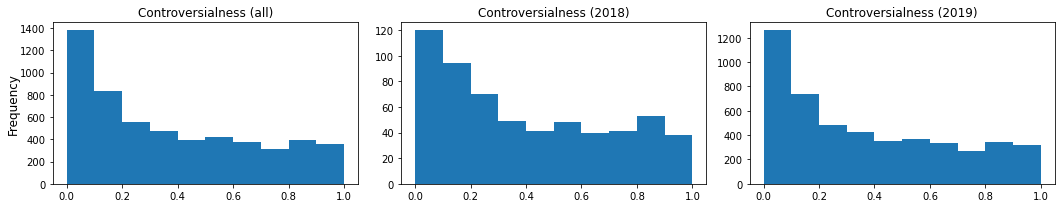

In [20]:
# Identify the controversialness distribution

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 3]
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)
n_bins = 10

_ = axs[0].hist(posts_df['controversialness'], bins=n_bins)
_ = axs[0].set_title('Controversialness (all)')
_ = axs[1].hist(posts_df[posts_df['created_utc']<1546318855]['controversialness'], bins=n_bins)
_ = axs[1].set_title('Controversialness (2018)')
_ = axs[2].hist(posts_df[posts_df['created_utc']>=1546318855]['controversialness'], bins=n_bins)
_ = axs[2].set_title('Controversialness (2019)')
_ = fig.supylabel('Frequency')

plt.show()

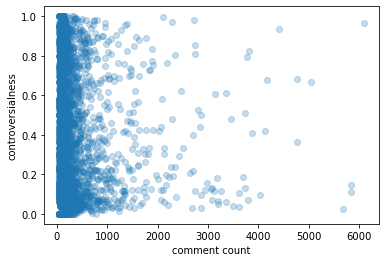

<AxesSubplot:xlabel='num_comments_range', ylabel='controversialness'>

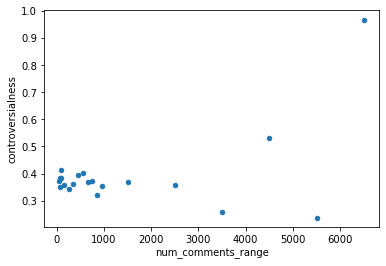

In [21]:
# Graph controversialness vs comment count

plt.rcParams['figure.figsize'] = [6, 4]
_ = plt.scatter(
    posts_df['num_comments'], 
    posts_df['controversialness'],
    alpha=0.25,
)
_ = plt.xlabel('comment count')
_ = plt.ylabel('controversialness')
plt.show()

ranges = [
    0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
    100, 200, 300, 400, 500, 600, 700, 800, 900, 
    1000, 2000, 3000, 4000, 5000, 6000, 7000]
temp = posts_df.groupby(pd.cut(posts_df.num_comments, ranges)).agg({'controversialness': ['mean']}).reset_index()
temp['num_comments_range'] = temp['num_comments'].apply(lambda x: (x.left + x.right) / 2)
temp.plot(kind="scatter", x="num_comments_range", y="controversialness")

In [22]:
posts_df.sort_values(by=['num_comments'], ascending=False)[:10][['title', 'id', 'num_comments', 'controversialness', 'controversialness_distrib']]

,title,id,num_comments,controversialness,controversialness_distrib
2422,AITA for refusing to lift something heavy for ...,avple4,6098,0.966089,"(665, 534, 21, 107, 21)"
3577,AITA for giving my ex wife a large amount of m...,b43t53,5849,0.113387,"(2533, 127, 46, 28, 8)"
4722,AITA for cutting my sister out of my life for ...,bb5r03,5844,0.145913,"(2391, 110, 36, 81, 45)"
2060,AITA for not letting my kids go on vacation wi...,asprlr,5681,0.026277,"(41, 3284, 4, 96, 9)"
620,AITA for telling my wife that when/if she quit...,abv65u,5041,0.667845,"(657, 338, 97, 40, 15)"
4512,AITA for leaving/ghosting my GF that was finan...,ba0ayr,4781,0.361732,"(1165, 96, 8, 163, 9)"
1185,AITA for telling my waitress's manager she did...,ak0zkc,4771,0.681858,"(355, 741, 34, 11, 2)"
3110,AITA for lying to my son's girlfriend's parents?,b0xd7g,4408,0.936342,"(558, 590, 23, 70, 3)"
4573,AITA for punishing my under-aged daughter for ...,bacigd,4177,0.679132,"(824, 329, 59, 125, 6)"
1967,AITA because my husband saw my post and says h...,arxwi6,4135,0.420682,"(659, 109, 13, 70, 1)"


# Build post graph, determine branchiness metrics per user, post

t3_9zglje
ThatIsANopeToThat
{'AutoModerator': ['t1_ea8zbp2'], 'ButtStuffJR': ['t1_ea8zjhn', 't1_ea91w03'], 'Basherrr559': ['t1_ea8zmtl', 't1_ea9epil'], 'Killairmanable': ['t1_ea8zotl', 't1_ea92a45', 't1_ea9urln'], 'icarebot': ['t1_ea8zoxb'], 'Zizzy00': ['t1_ea90anq'], 'shepkita': ['t1_ea90ctp'], 'N0Taqua': ['t1_ea90eao', 't1_ea94rw3', 't1_ea9hblc', 't1_eaa2dtk'], 'kafka123': ['t1_ea9200g'], 'fxckingr': ['t1_ea92aur'], 'Piemandinoman': ['t1_ea93ut5', 't1_ea9fgpp', 't1_ea9fw0y', 't1_ea9gl0i', 't1_ea9i3xn'], 'kitsunowl': ['t1_ea940sa'], 'Girl_in_space': ['t1_ea95799', 't1_eab3tgk'], 'KatFrog': ['t1_ea9797v'], 'anthropaedic': ['t1_ea97ilh'], 'rusty0123': ['t1_ea99tns', 't1_ea9grds'], 'jespo361': ['t1_ea9a9gi'], 'timelordoftheimpala': ['t1_ea9aifk'], 'Thriftyverse': ['t1_ea9bjqh'], 'dragonspeeddraco': ['t1_ea9bu8t'], 'HamanitaMuscaria': ['t1_ea9c27y', 't1_ea9cd1r', 't1_ea9cmtj', 't1_ea9cpko', 't1_ea9gafp', 't1_ea9hb2s', 't1_ea9i2l1', 't1_ea9l0gq', 't1_ea9l43y', 't1_ea9nmuc', 't1_ea9ol3l', '

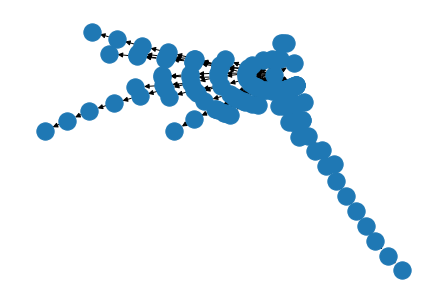

In [23]:
import networkx as nx

def collect_post_graphs(posts_df, comms_df):
    gAll = {}
    for _, post in posts_df.iterrows():
        g = nx.DiGraph()
        post_id = post['id']
        userResponders = {}
        for _, comment in comms_df[comms_df['link_id']==f't3_{post_id}'].iterrows():
            parentID = comment['parent_id']
            currentID = 't1_'+comment['id']
            author = comment['author']
            g.add_edge(parentID, currentID)
            g.nodes[currentID]['author'] = author
            if author not in userResponders:
                userResponders[author] = []
            userResponders[author].append(currentID)    
        gAll[f't3_{post_id}'] = {
            'post_graph': g,
            'user_op': post['author'],
            'user_responders': userResponders,
        }
    return gAll

# vis the graphs that got built
def graph_demo(gAll, postID=None):
    if postID==None:
        postID = list(gAll.keys())[0]
    postG = gAll[postID]['post_graph']
    # print(postG.nodes.data())
    nx.draw_kamada_kawai(
        postG, 
    #     node_color=[
    #         d['comment_author'] if 'comment_author' in d else gAll[postID]['user_op']
    #         for (n,d) in postG.nodes.data()
    #     ]
    )
    print(postID)
    print(gAll[postID]['user_op'])
    print(gAll[postID]['user_responders'])

temp = collect_post_graphs(posts_df[:25], comms_df)
graph_demo(temp)

In [24]:
import pickle

# Create a dictionary from t3-postid to post activity graph structure

if REWRITE_BACKUPS_FLAG:
    gAll = collect_post_graphs(posts_sizefilter_df, comms_sizefilter_df)
    with open('backup_gAll.pkl', 'wb') as f:
        pickle.dump(gAll, f)

# Recover from backup

with open('backup_gAll.pkl', 'rb') as f:
    gAll = pickle.load(f)

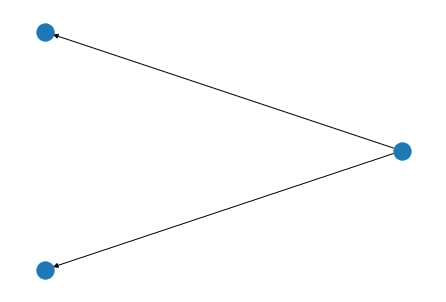

In [25]:
import statistics

# get tree unique to commenter's behavior
def comment_branch_tree(username, postID, gAll):
    # retrieve graph we are working with
    g = gAll[postID]['post_graph']
    # calculate path to each of the poster's comments
    commentPaths = {}
    for cID in gAll[postID]['user_responders'][username]:
        try:
            commentPaths[cID] = nx.shortest_path(g, postID, cID)
        finally:
            # print(f'{cID} broken path comment?')
            continue
    # starting from shortest path, build out tree of direct dependencies
    gPath = nx.DiGraph()
    nodesAdded = [postID]
    while len(commentPaths) > 0:
        closestCID = sorted(
            [(k, len(commentPaths[k])) for k in commentPaths],
            key=(lambda x: x[1]),
        )
        closestPath = commentPaths[closestCID[0][0]]
        closestCID = closestPath[-1]
        topLevel = True
        for n in nodesAdded:
            if nx.has_path(g, n, closestCID):
                topLevel = False
                gPath.add_edge(n, closestCID)
                nodesAdded = [closestCID]+nodesAdded
                break
        if topLevel:
            gPath.add_edge(postID, closestCID)
            nodesAdded = [closestCID]+nodesAdded
        commentPaths.pop(closestCID, None)
    return gPath

username = "TomatoesTooUmami"
postID = "t3_a2f8ac"
nx.draw_kamada_kawai(
    comment_branch_tree(username, postID, gAll), 
)

In [26]:
import statistics

# define some branchiness-related metrics
# path metric:
# count of how many unique paths are needed for all of the user's posts to be reached
def branchiness(username, postID, gAll):
    # get user-unique comment tree
    g = comment_branch_tree(username, postID, gAll)
    degrees = [d for (_,d) in g.out_degree()]
    # If there were no comments recognized for this user connected to the root text at all...
    if len(degrees)==0:
        return -1, -1, -1, -1, -1
    # comment count = total number of comments involved
    comment_count = len(degrees)-1 # do NOT count the root node, that's the OP
    # branch_count = number of nodes with outgoing degree 0
    branch_count = len([i for i in degrees if i==0])
    # branchiness = branch_count / number of comments
    branch_branchiness = branch_count / comment_count
    # avg degree = avg degree of nodes within the tree, excluding leaf nodes
    degree_avg = sum(degrees)/len([i for i in degrees if i!=0])
    # med degree = med degree of nodes within the tree, excluding leaf nodes
    degree_med = statistics.median([i for i in degrees if i!=0])
    return branch_count, branch_branchiness, degree_avg, degree_med, comment_count

username = "TomatoesTooUmami"
postID = "t3_a2f8ac"
print(branchiness(username, postID, gAll))

(2, 1.0, 2.0, 2, 2)


In [27]:
# Get the user's branchiness metrics in relation to each post they have participated in
def user_branchiness(posts_df, comms_df, gAll):
    tags = {
        'id':[], 'link_id':[], 
        'author': [], 
        'branch_count':[], 'branch_branchiness':[], 'branch_degree_avg':[], 'branch_degree_med':[], 'comment_count': []}
    temp = 0
    for (g_link_id, g_author), userpost_df in comms_df.groupby(['link_id', 'author'], sort=False):
        branch_count, branch_branchiness, degree_avg, degree_med, comment_count = branchiness(g_author, g_link_id, gAll)
        if branch_count!=-1:
            tags['id'].append(g_link_id[3:])
            tags['link_id'].append(g_link_id)
            tags['author'].append(g_author)
            tags['branch_count'].append(branch_count)
            tags['branch_branchiness'].append(branch_branchiness)
            tags['branch_degree_avg'].append(degree_avg)
            tags['branch_degree_med'].append(degree_med)
            tags['comment_count'].append(comment_count)
    return pd.DataFrame(tags)

temp = user_branchiness(posts_df, comms_df[:1000], gAll)
temp[:5]

,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count
0,9zglje,t3_9zglje,AutoModerator,1,1.000000,1.0,1.0,1
1,9zglje,t3_9zglje,ButtStuffJR,2,1.000000,2.0,2.0,2
2,9zglje,t3_9zglje,Basherrr559,1,0.500000,1.0,1.0,2
3,9zglje,t3_9zglje,Killairmanable,2,0.666667,1.5,1.5,3
4,9zglje,t3_9zglje,icarebot,1,1.000000,1.0,1.0,1


## Backup branchiness annotation

In [28]:
# Backup user-post correctness score annotations

if REWRITE_BACKUPS_FLAG:
    ann_peruserpost_branchiness_df = user_branchiness(posts_df, comms_df, gAll)
    ann_peruserpost_branchiness_df.to_csv(f'backup_ann_peruserpost_branchiness_df.csv', index=False)
    peruserpost_df = ann_peruserpost_branchiness_df

# Recover from backup

ann_peruserpost_branchiness_df = pd.read_csv(f'backup_ann_peruserpost_branchiness_df.csv')
peruserpost_df = pd.read_csv(f'backup_ann_peruserpost_branchiness_df.csv')

ann_peruserpost_branchiness_df[:2]
peruserpost_df[:2]

,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count
0,9zglje,t3_9zglje,AutoModerator,1,1.0,1.0,1.0,1
1,9zglje,t3_9zglje,ButtStuffJR,2,1.0,2.0,2.0,2


,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count
0,9zglje,t3_9zglje,AutoModerator,1,1.0,1.0,1.0,1
1,9zglje,t3_9zglje,ButtStuffJR,2,1.0,2.0,2.0,2


## Visualize branchiness distributions

In [30]:
# Create filtered dataset to avoid graphing branchiness of filtered-out users and OPs
temp_branch_df = ann_peruserpost_branchiness_df
temp_branch_df = temp_branch_df[temp_branch_df['author'].apply(
    lambda x: x not in restricted_users_list
)]
temp_branch_df = temp_branch_df[temp_branch_df.apply(
    lambda r: r['author'] != gAll[r['link_id']]['user_op'],
    axis='columns',
)]
temp_branch_df[:5]

,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count
1,9zglje,t3_9zglje,ButtStuffJR,2,1.000000,2.0,2.0,2
2,9zglje,t3_9zglje,Basherrr559,1,0.500000,1.0,1.0,2
3,9zglje,t3_9zglje,Killairmanable,2,0.666667,1.5,1.5,3
4,9zglje,t3_9zglje,icarebot,1,1.000000,1.0,1.0,1
5,9zglje,t3_9zglje,Zizzy00,1,1.000000,1.0,1.0,1


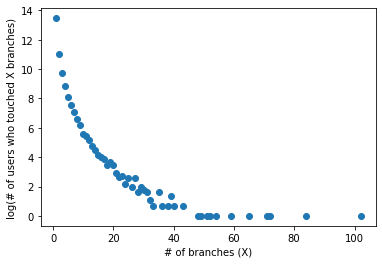

In [31]:
# Plot number of branches vs number of users who have created that many branches
import math
import matplotlib.pyplot as plt

temp = []
for g_branch_count, df in temp_branch_df.groupby(['branch_count'], sort=False):
    temp.append( (g_branch_count, len(df)) )

_ = plt.scatter(
    [x for (x, _) in temp], 
    [math.log(y) for (_, y) in temp], 
)
_ = plt.xlabel('# of branches (X)')
_ = plt.ylabel('log(# of users who touched X branches)')
plt.show()

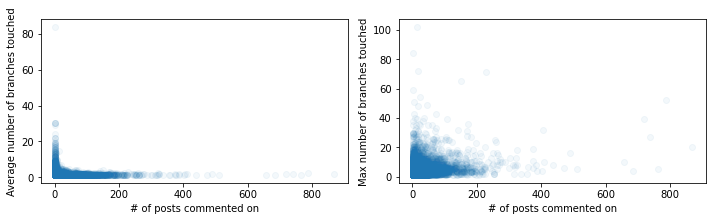

In [32]:
# Plot relationship between subreddit activity (number of posts involved in) vs number of branches created
import math
import matplotlib.pyplot as plt

temp = []
for g_author, df in temp_branch_df.groupby(['author'], sort=False):
    temp_branches = df['branch_count']
    temp.append( (g_author, len(df), sum(temp_branches)/len(temp_branches), max(temp_branches)) )

plt.rcParams['figure.figsize'] = [10, 3]
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)

_ = axs[0].scatter(
    [x for (_, x, _, _) in temp], 
    [y for (_, _, y, _) in temp], 
    alpha=0.05
)
_ = axs[0].set_xlabel('# of posts commented on')
_ = axs[0].set_ylabel('Average number of branches touched')

_ = axs[1].scatter(
    [x for (_, x, _, _) in temp], 
    [y for (_, _, _, y) in temp], 
    alpha=0.05
)
_ = axs[1].set_xlabel('# of posts commented on')
_ = axs[1].set_ylabel('Max number of branches touched')

plt.show()

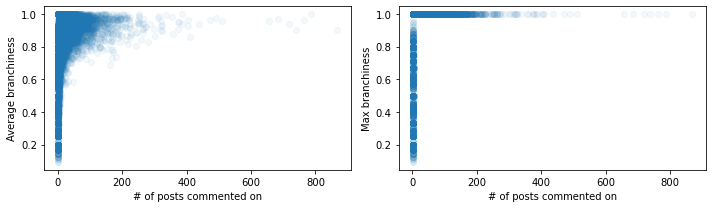

In [33]:
# Plot relationship between subreddit activity (number of posts involved in) vs branchiness
import math
import matplotlib.pyplot as plt

temp = []
for g_author, df in temp_branch_df.groupby(['author'], sort=False):
    temp_branchiness = df['branch_branchiness']
    temp.append( (g_author, len(df), sum(temp_branchiness)/len(temp_branchiness), max(temp_branchiness)) )

plt.rcParams['figure.figsize'] = [10, 3]
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)

_ = axs[0].scatter(
    [x for (_, x, _, _) in temp], 
    [y for (_, _, y, _) in temp], 
    alpha=0.05
)
_ = axs[0].set_xlabel('# of posts commented on')
_ = axs[0].set_ylabel('Average branchiness')

_ = axs[1].scatter(
    [x for (_, x, _, _) in temp], 
    [y for (_, _, _, y) in temp], 
    alpha=0.05
)
_ = axs[1].set_xlabel('# of posts commented on')
_ = axs[1].set_ylabel('Max branchiness')

plt.show()

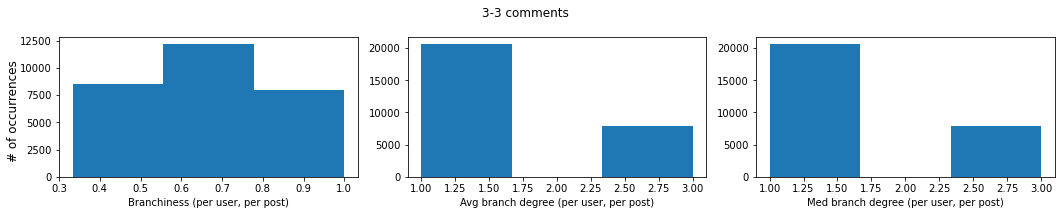

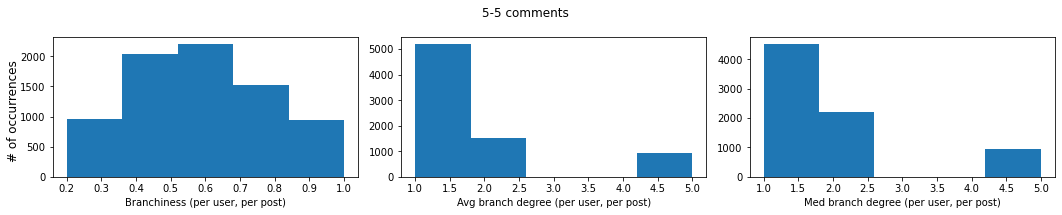

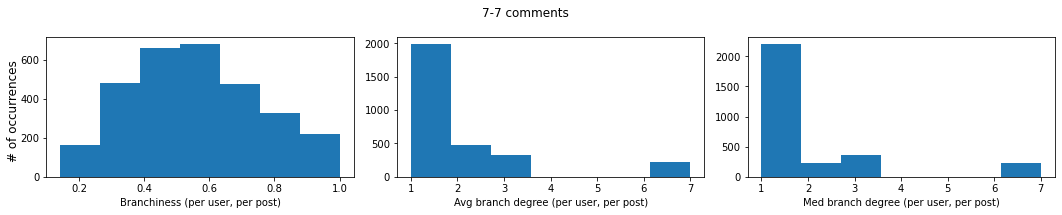

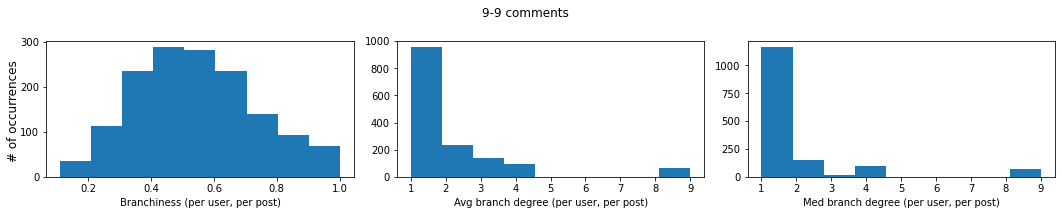

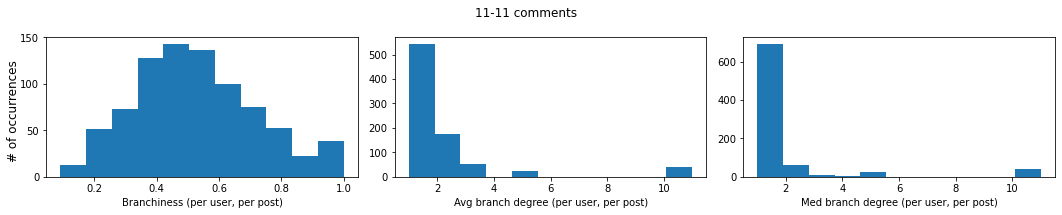

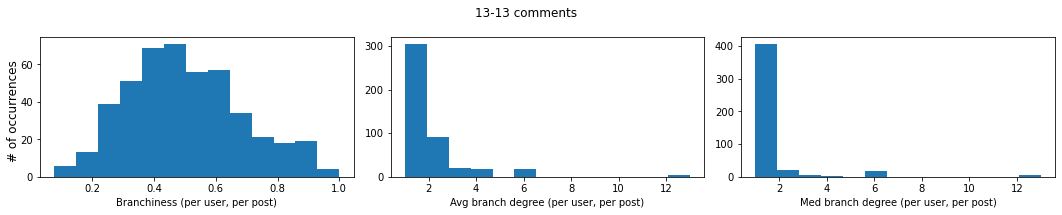

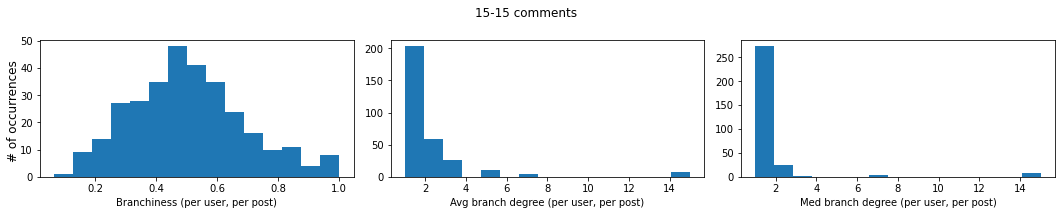

In [34]:
# Plot frequency of different branchiness metric values
import math
import matplotlib.pyplot as plt
import numpy as np

def vis_comment_ctrl(ann_userpost_branch_df, min_count, max_count=None):
    if max_count is None:
        max_count = min_count
    
    plt.rcParams['figure.figsize'] = [15, 3]
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)
    _ = fig.supylabel('# of occurrences')
    num_bins = np.lcm.reduce(list(range(min_count, max_count+1)))
    
    temp_df = ann_userpost_branch_df
    temp_df = temp_df[temp_df['comment_count']>=min_count]
    temp_df = temp_df[temp_df['comment_count']<=max_count]
    _ = fig.suptitle(f'{min_count}-{max_count} comments')
    temp = temp_df['branch_branchiness']
    _ = axs[0].hist(temp, bins=num_bins)
    _ = axs[0].set_xlabel('Branchiness (per user, per post)')
    temp = temp_df['branch_degree_avg']
    _ = axs[1].hist(temp, bins=num_bins)
    _ = axs[1].set_xlabel('Avg branch degree (per user, per post)')
    temp = temp_df['branch_degree_med']
    _ = axs[2].hist(temp, bins=num_bins)
    _ = axs[2].set_xlabel('Med branch degree (per user, per post)')
    plt.show()

vis_comment_ctrl(temp_branch_df, 3)
vis_comment_ctrl(temp_branch_df, 5)
vis_comment_ctrl(temp_branch_df, 7)
vis_comment_ctrl(temp_branch_df, 9)
vis_comment_ctrl(temp_branch_df, 11)
vis_comment_ctrl(temp_branch_df, 13)
vis_comment_ctrl(temp_branch_df, 15)

# Determine user correctness per user, post

In [35]:
# Get the user's judgement accuracy in relation to each post they have participated in
def user_judgement(posts_df, comms_df):
    tags = {
        'id':[], 'link_id':[],
        'author': [], 'general_judgement_correct':[]}
    temp = 0
    for (g_link_id, g_author), userpost_df in comms_df.groupby(['link_id', 'author'], sort=False):
        g_post = posts_df[posts_df['id'] == g_link_id[3:]].iloc[0]
        correctness = [i for i in userpost_df['judgement_correct'] if i>=0]
        tags['id'].append(g_link_id[3:])
        tags['link_id'].append(g_link_id)
        tags['author'].append(g_author)
        tags['general_judgement_correct'].append( sum(correctness)/len(correctness) if len(correctness)>0 else None )
    return pd.DataFrame(tags)

temp = user_judgement(posts_df, comms_df[:1000])
temp[:5]

,id,link_id,author,general_judgement_correct
0,9zglje,t3_9zglje,AutoModerator,NaN
1,9zglje,t3_9zglje,ButtStuffJR,1.0
2,9zglje,t3_9zglje,Basherrr559,1.0
3,9zglje,t3_9zglje,Killairmanable,1.0
4,9zglje,t3_9zglje,icarebot,NaN


## Backup correctness annotation

In [36]:
# Backup user-post correctness score annotations

if REWRITE_BACKUPS_FLAG:
    ann_peruserpost_correctness_df = user_judgement(posts_df, comms_df)
    ann_peruserpost_correctness_df.to_csv(f'backup_ann_peruserpost_correctness_df.csv', index=False)
    peruserpost_df = peruserpost_df.merge(
        ann_peruserpost_correctness_df, left_on=['link_id', 'id', 'author'], right_on=['link_id', 'id', 'author'])
    peruserpost_df.to_csv(f'backup_peruserpost_df.csv', index=False)

# Recover from backup

ann_peruserpost_correctness_df = pd.read_csv(f'backup_ann_peruserpost_correctness_df.csv')
peruserpost_df = pd.read_csv(f'backup_peruserpost_df.csv')

ann_peruserpost_correctness_df[:2]
peruserpost_df[:2]

,id,link_id,author,general_judgement_correct
0,9zglje,t3_9zglje,AutoModerator,NaN
1,9zglje,t3_9zglje,ButtStuffJR,1.0


,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count,general_judgement_correct
0,9zglje,t3_9zglje,AutoModerator,1,1.0,1.0,1.0,1,NaN
1,9zglje,t3_9zglje,ButtStuffJR,2,1.0,2.0,2.0,2,1.0


## Visualize correctness

In [37]:
# Create filtered dataset to avoid graphing data of filtered-out users and OPs
temp_peruserpost_df = peruserpost_df
temp_peruserpost_df = temp_peruserpost_df[temp_peruserpost_df['author'].apply(
    lambda x: x not in restricted_users_list
)]
temp_peruserpost_df = temp_peruserpost_df[temp_peruserpost_df.apply(
    lambda r: r['author'] != gAll[r['link_id']]['user_op'],
    axis='columns',
)]

# Also remove NaN entries
temp_peruserpost_df = temp_peruserpost_df[temp_peruserpost_df['general_judgement_correct']>=-1]

temp_peruserpost_df[:5]

,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count,general_judgement_correct
1,9zglje,t3_9zglje,ButtStuffJR,2,1.000000,2.000000,2.0,2,1.0
2,9zglje,t3_9zglje,Basherrr559,1,0.500000,1.000000,1.0,2,1.0
3,9zglje,t3_9zglje,Killairmanable,2,0.666667,1.500000,1.5,3,1.0
6,9zglje,t3_9zglje,shepkita,1,1.000000,1.000000,1.0,1,0.0
7,9zglje,t3_9zglje,N0Taqua,2,0.500000,1.333333,1.0,4,0.0


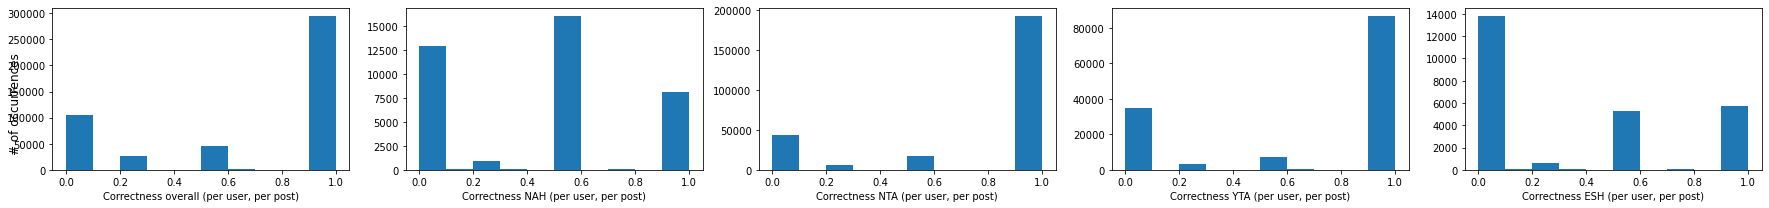

In [38]:
# Plot frequency of different correctness metric values
import math
import matplotlib.pyplot as plt
    
plt.rcParams['figure.figsize'] = [25, 3]
fig, axs = plt.subplots(1, 5, sharey=False, tight_layout=True)
_ = fig.supylabel('# of occurrences')

temp_df = temp_peruserpost_df
temp = temp_df['general_judgement_correct']
_ = axs[0].hist(temp, bins=10)
_ = axs[0].set_xlabel('Correctness overall (per user, per post)')

temp_posts_df = posts_df[posts_df['final_judgement']=='NAH']
temp_df = temp_peruserpost_df[temp_peruserpost_df.apply(
    lambda x: x['id'] in temp_posts_df['id'].values, 
    axis='columns')]
temp = temp_df['general_judgement_correct']
_ = axs[1].hist(temp, bins=10)
_ = axs[1].set_xlabel('Correctness NAH (per user, per post)')

temp_posts_df = posts_df[posts_df['final_judgement']=='NTA']
temp_df = temp_peruserpost_df[temp_peruserpost_df.apply(
    lambda x: x['id'] in temp_posts_df['id'].values, 
    axis='columns')]
temp = temp_df['general_judgement_correct']
_ = axs[2].hist(temp, bins=10)
_ = axs[2].set_xlabel('Correctness NTA (per user, per post)')

temp_posts_df = posts_df[posts_df['final_judgement']=='YTA']
temp_df = temp_peruserpost_df[temp_peruserpost_df.apply(
    lambda x: x['id'] in temp_posts_df['id'].values, 
    axis='columns')]
temp = temp_df['general_judgement_correct']
_ = axs[3].hist(temp, bins=10)
_ = axs[3].set_xlabel('Correctness YTA (per user, per post)')

temp_posts_df = posts_df[posts_df['final_judgement']=='ESH']
temp_df = temp_peruserpost_df[temp_peruserpost_df.apply(
    lambda x: x['id'] in temp_posts_df['id'].values, 
    axis='columns')]
temp = temp_df['general_judgement_correct']
_ = axs[4].hist(temp, bins=10)
_ = axs[4].set_xlabel('Correctness ESH (per user, per post)')

plt.show()

# Present a breakdown of the dataframe data available

In [40]:
# Main data

# all size-filtered modern posts with annotations: controversialness
print('posts_df')
posts_df[:2]

# all size-filtered modern comments with annotations: judgement, correctness
print('comms_df')
comms_df[:2]

# all per-user-post pairings with annotations: overall correctness, branchiness
print('peruserpost_df')
peruserpost_df[:2]

print('================')

# Annotations data, shouldn't be fully needed

# All size-filtered modern posts without annotations
print('posts_sizefilter_df')
posts_sizefilter_df[:2]

# All size-filtered modern comments without annotations
print('comms_sizefilter_df')
comms_sizefilter_df[:2]

# Pure annotations per size-filtered modern post: final judgements
print('ann_posts_finaljudgement_df')
ann_posts_finaljudgement_df[:2]

# Pure annotations per size-filtered modern comment: individual judgement tag
print('ann_comms_judgements_df')
ann_comms_judgements_df[:2]

# Pure annotations per size-filtered modern comment: individual correctness
print('ann_comms_correctness_df')
ann_comms_correctness_df[:2]

# Pure annotations per size-filtered modern user-post pairing: branchiness
print('ann_peruserpost_branchiness_df')
ann_peruserpost_branchiness_df[:2]

# Pure annotations per size-filtered modern user-post pairing: overall correctness
print('ann_peruserpost_correctness_df')
ann_peruserpost_correctness_df[:2]

posts_df


,author,author_flair_css_class,author_flair_text,brand_safe,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,retrieved_on,score,selftext,spoiler,stickied,subreddit,subreddit_id,subreddit_type,suggested_sort,thumbnail,title,url,whitelist_status,thumbnail_height,thumbnail_width,link_flair_text,banned_by,edited,media.oembed.description,media.oembed.height,media.oembed.html,media.oembed.provider_name,media.oembed.provider_url,media.oembed.thumbnail_height,media.oembed.thumbnail_url,media.oembed.thumbnail_width,media.oembed.title,media.oembed.type,media.oembed.version,media.oembed.width,media.type,media_embed.content,media_embed.height,media_embed.scrolling,media_embed.width,secure_media.oembed.description,secure_media.oembed.height,secure_media.oembed.html,secure_media.oembed.provider_name,secure_media.oembed.provider_url,secure_media.oembed.thumbnail_height,secure_media.oembed.thumbnail_url,secure_media.oembed.thumbnail_width,secure_media.oembed.title,secure_media.oembed.type,secure_media.oembed.version,secure_media.oembed.width,secure_media.type,secure_media_embed.content,secure_media_embed.height,secure_media_embed.media_domain_url,secure_media_embed.scrolling,secure_media_embed.width,link_flair_css_class,post_hint,preview.enabled,preview.images,author_flair_richtext,author_flair_type,link_flair_richtext,link_flair_text_color,link_flair_type,rte_mode,author_flair_background_color,author_flair_text_color,media.oembed.author_name,media.oembed.author_url,secure_media.oembed.author_name,secure_media.oembed.author_url,link_flair_background_color,link_flair_template_id,author_cakeday,gilded,send_replies,no_follow,subreddit_subscribers,crosspost_parent,crosspost_parent_list,is_original_content,wls,pwls,media_only,author_id,is_meta,archived,author_created_utc,author_flair_template_id,author_fullname,author_patreon_flair,can_gild,category,content_categories,distinguished,hidden,is_robot_indexable,media,quarantine,removal_reason,secure_media,subreddit_name_prefixed,gildings.gid_1,gildings.gid_2,gildings.gid_3,all_awardings,allow_live_comments,awarders,total_awards_received,treatment_tags,upvote_ratio,author_premium,removed_by_category,updated_utc,preview.reddit_video_preview.dash_url,preview.reddit_video_preview.duration,preview.reddit_video_preview.fallback_url,preview.reddit_video_preview.height,preview.reddit_video_preview.hls_url,preview.reddit_video_preview.is_gif,preview.reddit_video_preview.scrubber_media_url,preview.reddit_video_preview.transcoding_status,preview.reddit_video_preview.width,steward_reports,og_description,og_title,removed_by,final_judgement,controversialness,controversialness_distrib
0,ThatIsANopeToThat,NaN,NaN,NaN,False,False,1542911466,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zglje,True,False,True,False,False,146,0,False,house_only,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,False,1542911467,1,"I am a law abiding citizen, always have been a...",False,False,AmItheAsshole,t5_2xhvq,public,top,self,AITA for letting a friend know that their grou...,https://www.reddit.com/r/AmItheAsshole/comment...,house_only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],text,[],dark,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,200625.0,NaN,NaN,False,1.0,1.0,False,NaN,False,NaN,NaN,NaN,t2_2nd211bo,False,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YTA,0.555556,"(10, 26, 0, 0, 0)"
1,CheesecakeTummyache,NaN,NaN,NaN,False,False,1542921448,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zi2oe,True,False,True,False,False,124,0,False,house_only,/r/AmItheAsshole/comments/9zi2oe/aita_for_not_...,Fa

comms_df


,approved_at_utc,author,author_flair_css_class,author_flair_text,banned_at_utc,body,can_mod_post,collapsed,collapsed_reason,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,author_cakeday,author_flair_background_color,author_flair_richtext,author_flair_text_color,author_flair_type,no_follow,rte_mode,send_replies,author_flair_template_id,author_id,author_fullname,gildings.gid_1,gildings.gid_2,gildings.gid_3,author_patreon_flair,all_awardings,locked,total_awards_received,associated_award,author_premium,awarders,collapsed_because_crowd_control,comment_type,top_awarded_type,treatment_tags,steward_reports,judgement_tag,judgement_correct
0,NaN,AutoModerator,NaN,NaN,NaN,^^^^AUTOMOD ***This is a copy of the above po...,False,False,NaN,1542911466,moderator,False,ea8zbp2,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542911e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,False,NaN,NaN,t2_6l4z3,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ButtStuffJR,badge,Certified Proctologist,NaN,"I understand you don't want to go into detail,...",False,False,NaN,1542911661,NaN,False,ea8zjhn,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542912e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],dark,text,True,NaN,True,NaN,NaN,t2_23lg4kgq,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YTA,1.0


peruserpost_df


,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count,general_judgement_correct
0,9zglje,t3_9zglje,AutoModerator,1,1.0,1.0,1.0,1,NaN
1,9zglje,t3_9zglje,ButtStuffJR,2,1.0,2.0,2.0,2,1.0


posts_sizefilter_df


,author,author_flair_css_class,author_flair_text,brand_safe,can_mod_post,contest_mode,created_utc,domain,full_link,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,retrieved_on,score,selftext,spoiler,stickied,subreddit,subreddit_id,subreddit_type,suggested_sort,thumbnail,title,url,whitelist_status,thumbnail_height,thumbnail_width,link_flair_text,banned_by,edited,media.oembed.description,media.oembed.height,media.oembed.html,media.oembed.provider_name,media.oembed.provider_url,media.oembed.thumbnail_height,media.oembed.thumbnail_url,media.oembed.thumbnail_width,media.oembed.title,media.oembed.type,media.oembed.version,media.oembed.width,media.type,media_embed.content,media_embed.height,media_embed.scrolling,media_embed.width,secure_media.oembed.description,secure_media.oembed.height,secure_media.oembed.html,secure_media.oembed.provider_name,secure_media.oembed.provider_url,secure_media.oembed.thumbnail_height,secure_media.oembed.thumbnail_url,secure_media.oembed.thumbnail_width,secure_media.oembed.title,secure_media.oembed.type,secure_media.oembed.version,secure_media.oembed.width,secure_media.type,secure_media_embed.content,secure_media_embed.height,secure_media_embed.media_domain_url,secure_media_embed.scrolling,secure_media_embed.width,link_flair_css_class,post_hint,preview.enabled,preview.images,author_flair_richtext,author_flair_type,link_flair_richtext,link_flair_text_color,link_flair_type,rte_mode,author_flair_background_color,author_flair_text_color,media.oembed.author_name,media.oembed.author_url,secure_media.oembed.author_name,secure_media.oembed.author_url,link_flair_background_color,link_flair_template_id,author_cakeday,gilded,send_replies,no_follow,subreddit_subscribers,crosspost_parent,crosspost_parent_list,is_original_content,wls,pwls,media_only,author_id,is_meta,archived,author_created_utc,author_flair_template_id,author_fullname,author_patreon_flair,can_gild,category,content_categories,distinguished,hidden,is_robot_indexable,media,quarantine,removal_reason,secure_media,subreddit_name_prefixed,gildings.gid_1,gildings.gid_2,gildings.gid_3,all_awardings,allow_live_comments,awarders,total_awards_received,treatment_tags,upvote_ratio,author_premium,removed_by_category,updated_utc,preview.reddit_video_preview.dash_url,preview.reddit_video_preview.duration,preview.reddit_video_preview.fallback_url,preview.reddit_video_preview.height,preview.reddit_video_preview.hls_url,preview.reddit_video_preview.is_gif,preview.reddit_video_preview.scrubber_media_url,preview.reddit_video_preview.transcoding_status,preview.reddit_video_preview.width,steward_reports,og_description,og_title,removed_by
0,ThatIsANopeToThat,NaN,NaN,NaN,False,False,1542911466,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zglje,True,False,True,False,False,146,0,False,house_only,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,False,1542911467,1,"I am a law abiding citizen, always have been a...",False,False,AmItheAsshole,t5_2xhvq,public,top,self,AITA for letting a friend know that their grou...,https://www.reddit.com/r/AmItheAsshole/comment...,house_only,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],text,[],dark,text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,200625.0,NaN,NaN,False,1.0,1.0,False,NaN,False,NaN,NaN,NaN,t2_2nd211bo,False,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CheesecakeTummyache,NaN,NaN,NaN,False,False,1542921448,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,9zi2oe,True,False,True,False,False,124,0,False,house_only,/r/AmItheAsshole/comments/9zi2oe/aita_for_not_...,False,1542921450,1,Context: me and my friend have been friends si...,False,False,AmItheAsshole,

comms_sizefilter_df


,approved_at_utc,author,author_flair_css_class,author_flair_text,banned_at_utc,body,can_mod_post,collapsed,collapsed_reason,created_utc,distinguished,edited,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,author_cakeday,author_flair_background_color,author_flair_richtext,author_flair_text_color,author_flair_type,no_follow,rte_mode,send_replies,author_flair_template_id,author_id,author_fullname,gildings.gid_1,gildings.gid_2,gildings.gid_3,author_patreon_flair,all_awardings,locked,total_awards_received,associated_award,author_premium,awarders,collapsed_because_crowd_control,comment_type,top_awarded_type,treatment_tags,steward_reports
0,NaN,AutoModerator,NaN,NaN,NaN,^^^^AUTOMOD ***This is a copy of the above po...,False,False,NaN,1542911466,moderator,False,ea8zbp2,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542911e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],NaN,text,True,NaN,False,NaN,NaN,t2_6l4z3,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ButtStuffJR,badge,Certified Proctologist,NaN,"I understand you don't want to go into detail,...",False,False,NaN,1542911661,NaN,False,ea8zjhn,False,t3_9zglje,t3_9zglje,/r/AmItheAsshole/comments/9zglje/aita_for_lett...,1.542912e+09,1.0,False,AmItheAsshole,t5_2xhvq,NaN,NaN,[],dark,text,True,NaN,True,NaN,NaN,t2_23lg4kgq,0.0,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ann_posts_finaljudgement_df


,id,final_judgement,controversialness,controversialness_distrib
0,9zglje,YTA,0.555556,"(10, 26, 0, 0, 0)"
1,9zi2oe,NTA,0.210526,"(51, 6, 0, 0, 0)"


ann_comms_judgements_df


,id,judgement_tag
0,ea8zbp2,NaN
1,ea8zjhn,YTA


ann_comms_correctness_df


,link_id,id,judgement_correct
0,t3_9zglje,ea8zjhn,1.0
1,t3_9zglje,ea8zmtl,1.0


ann_peruserpost_branchiness_df


,id,link_id,author,branch_count,branch_branchiness,branch_degree_avg,branch_degree_med,comment_count
0,9zglje,t3_9zglje,AutoModerator,1,1.0,1.0,1.0,1
1,9zglje,t3_9zglje,ButtStuffJR,2,1.0,2.0,2.0,2


ann_peruserpost_correctness_df


,id,link_id,author,general_judgement_correct
0,9zglje,t3_9zglje,AutoModerator,NaN
1,9zglje,t3_9zglje,ButtStuffJR,1.0
